In [1]:
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
sys.path.append(os.path.abspath(".."))  #TODO: MAKE THE SRC PACKAGE WORK
#from src.training.train import train_model, train_cellfate
from src.evaluation.evaluate import Evaluation
from src.training.loss_functions import *

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from keras.layers import Lambda, Input, GaussianNoise,concatenate, Dense, Dropout, Conv2D, Add, UpSampling2D, Dot, Conv2DTranspose, Activation, Reshape, InputSpec, LeakyReLU, Flatten, BatchNormalization, SpectralNormalization, GlobalAveragePooling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
import keras.backend as K
from keras import activations, initializers, regularizers, constraints
from tensorflow.python.keras.utils import conv_utils
from keras.layers import Dense, Conv1D, Conv2D, Conv3D, Conv2DTranspose, Embedding
import tensorflow as tf
from keras.models import load_model
from keras.applications import VGG19, VGG16
from keras.activations import swish
from keras.initializers import glorot_uniform, glorot_normal, GlorotUniform
from keras.constraints import max_norm, UnitNorm
from ipywidgets import interact, IntSlider
import tifffile as tiff
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [3]:
x_train = np.load('../data/stretched_x_train.npy')
y_train = np.load('../data/train_labels.npy')
x_test = np.load('../data/stretched_x_test.npy')
y_test = np.load('../data/test_labels.npy')

# Full cell fate

In [4]:


base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

num_classes = len(np.unique(y_train))
# Build a new model for your task
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling to flatten feature maps
x = Dense(512, activation='relu')(x)  
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)
# Final model
clf_model = Model(inputs=base_model.input, outputs=outputs)

# Freeze VGG19 layers for transfer learning
for layer in base_model.layers:
    layer.trainable = False

tf.keras.utils.set_random_seed(812)

clf_model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.0001, clipvalue=0.5), metrics=["accuracy"])

clf_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,978,370 (57.14 MB)

 Trainable params: 263,682 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.5093 - loss: 0.7432 - val_accuracy: 0.6377 - val_loss: 0.6469
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.5950 - loss: 0.6773 - val_accuracy: 0.6884 - val_loss: 0.6123
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.6154 - loss: 0.6649 - val_accuracy: 0.6522 - val_loss: 0.6361
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.6389 - loss: 0.6513 - val_accuracy: 0.6449 - val_loss: 0.6264
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.6405 - loss: 0.6390 - val_accuracy: 0.6449 - val_loss: 0.6193
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.6525 - loss: 0.6235 - val_accuracy: 0.6377 - val_loss: 0.6249
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.6451 - loss: 0.6203 - val_accuracy: 0.6304 - val_loss: 0.6263
Epoch 8/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.6625 - loss: 0.6099 - val_accuracy: 0.

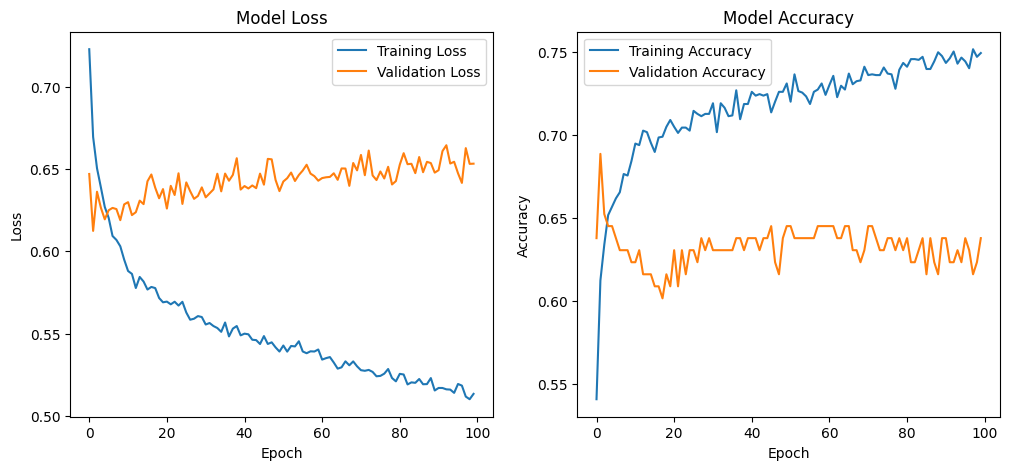

In [5]:
def process_for_vgg(image): # the input is (20, 20)
    # Pad to make it the minimum size for VGG (32, 32, 3)
    image = np.expand_dims(image, axis=-1)
    padded_x_train = np.pad(image, ((0, 0), (6, 6), (6, 6), (0, 0)), mode='constant')
    padded_x_train = np.concatenate((padded_x_train, padded_x_train), axis=-1)
    padded_x_train = np.concatenate((padded_x_train, padded_x_train[:,:,:,0:1]), axis=-1)
    return padded_x_train

x_val, x_test_, y_val, y_test_ = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

history = clf_model.fit(process_for_vgg(x_train), y_train, batch_size=32, epochs=100, validation_data=(process_for_vgg(x_val), y_val))

plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
[[0.62162162 0.37837838]
 [0.32142857 0.67857143]]


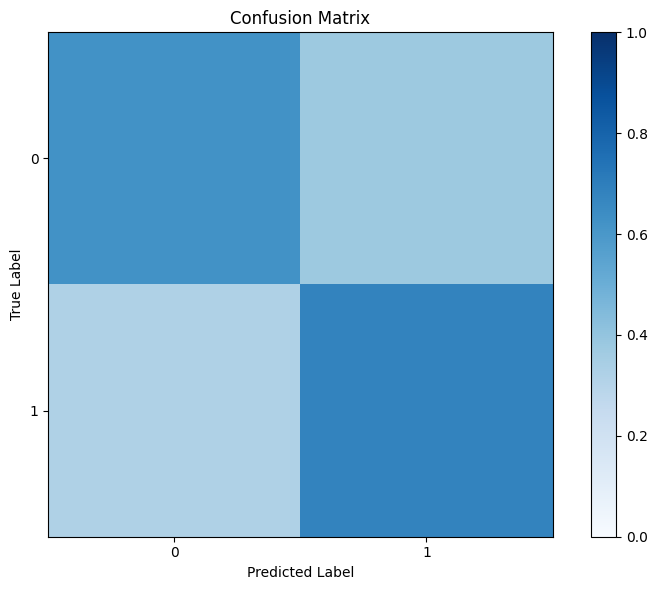

In [6]:
num_classes = len(np.unique(y_train))
y_pred = clf_model.predict(process_for_vgg(x_test_))
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_test_, y_pred_classes)

class_sums = cm.sum(axis=1, keepdims=True)
conf_matrix_normalized = cm / class_sums

print(conf_matrix_normalized)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_normalized, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Getting pretrained full model without classifier

In [4]:
from src.models import Encoder, Decoder, Discriminator, mlp_classifier

config = {
    'batch_size': 30,
    'epochs': 100,
    'learning_rate': 0.001,
    'seed': 42,
    'latent_dim': 10,
    'GaussianNoise_std': 0.003,
    'lambda_recon': 5, 
    'lambda_adv': 0.05,
    'lambda_clf': 0.05,
    'lambda_cov': 0.1,
}

img_shape = (x_train.shape[1], x_train.shape[2], 1)
encoder = Encoder(img_shape=img_shape, latent_dim=config['latent_dim'], num_classes=2, gaussian_noise_std=config['GaussianNoise_std']).model
decoder = Decoder(latent_dim=config['latent_dim'], img_shape=img_shape, gaussian_noise_std=config['GaussianNoise_std']).model
discriminator = Discriminator(latent_dim=config['latent_dim']).model

# encoder.load_weights("/Users/inescunha/Downloads/drive-download-20250120T120110Z-001/encoder.weights.h5")
# decoder.load_weights("/Users/inescunha/Downloads/drive-download-20250120T120110Z-001/decoder.weights.h5")

encoder.load_weights("/Users/inescunha/Documents/GitHub/CellFate/results/models/encoder.weights.h5")
decoder.load_weights("/Users/inescunha/Documents/GitHub/CellFate/results/models/decoder.weights.h5")
discriminator.load_weights("/Users/inescunha/Documents/GitHub/CellFate/results/models/discriminator.weights.h5")

/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [8]:
encoder.predict(x_train).shape

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


(2184, 10)

In [10]:
tf.keras.utils.set_random_seed(config['seed'])

classifier = mlp_classifier(latent_dim=config['latent_dim']) #[:, [3, 8]] 

# Train the classifier
classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config['learning_rate']), metrics=['accuracy'])
classifier.summary()

x_val, x_test_, y_val, y_test_ = train_test_split(encoder.predict(x_test), y_test, test_size=0.5, random_state=42) # 42 random state

history = classifier.fit(encoder.predict(x_train), y_train, batch_size=config['batch_size'], epochs=config['epochs'], validation_data=(x_val, y_val)) # 

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 32)             │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 914 (3.57 KB)

 Trainable params: 914 (3.57 KB)

 Non-trainable params: 0 (0.00 B)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4880 - loss: 0.7976 - val_accuracy: 0.6087 - val_loss: 0.6540
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - accuracy: 0.5900 - loss: 0.6747 - val_accuracy: 0.6667 - val_loss: 0.6190
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - accuracy: 0.6274 - loss: 0.6641 - val_accuracy: 0.7101 - val_loss: 0.5912
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - accuracy: 0.6482 - loss: 0.6410 - val_accuracy: 0.6594 - val_loss: 0.6068
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - accuracy: 0.6560 - loss: 0.6332 - val_accuracy: 0.6594 - val_loss: 0.5933
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - accuracy: 0.6502 - loss: 0.6228 - val_accuracy: 0.6377 - val_loss: 0.5955
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - accuracy: 0.6770 - loss: 0.6155 - val_accuracy: 0.6377 - val_loss: 0.6082
Epoch 8/100
73/73 ━━━━━

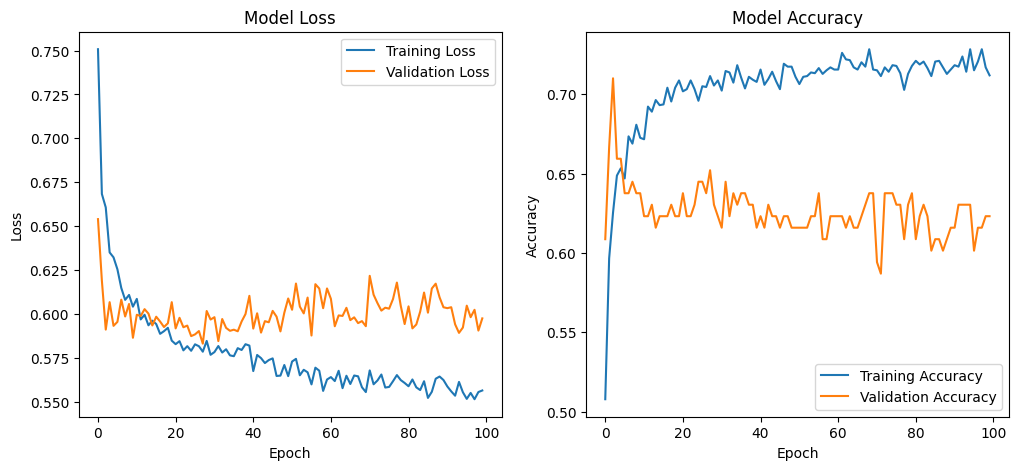

In [11]:
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

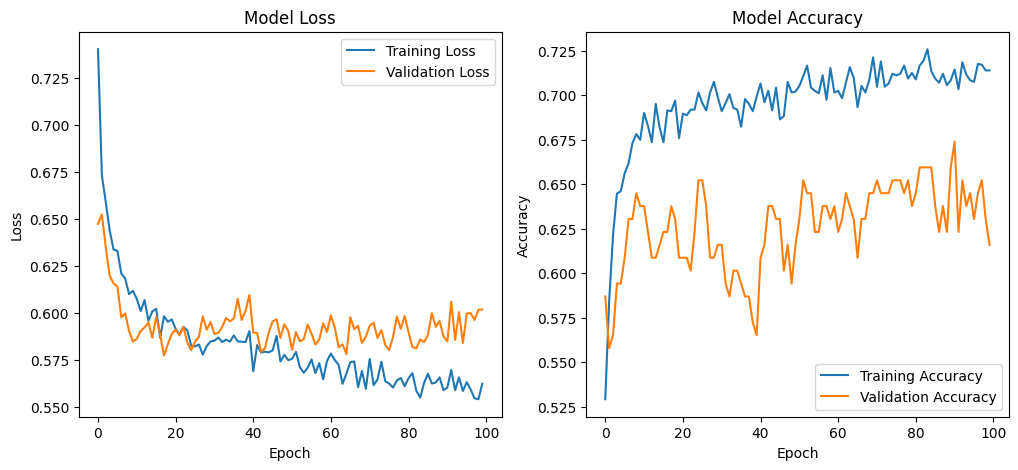

In [6]:
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[[0.57657658 0.42342342]
 [0.21428571 0.78571429]]


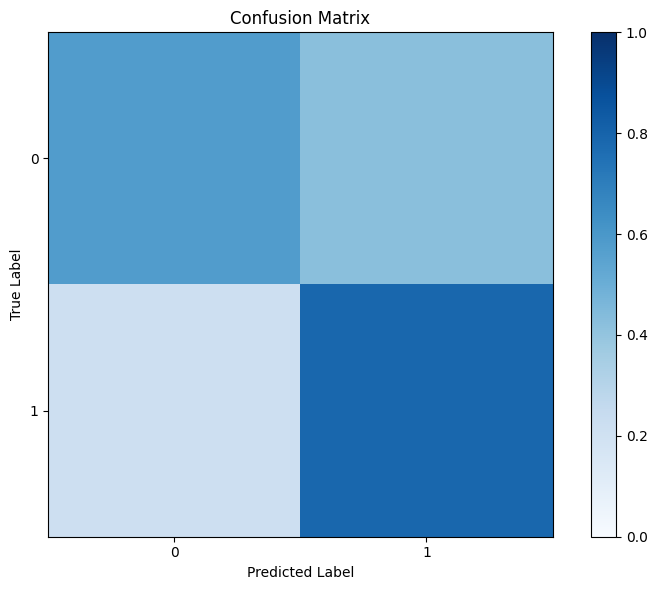

In [12]:
num_classes = len(np.unique(y_train))
y_pred = classifier.predict(x_test_)
# y_pred_classes = np.argmax(y_pred, axis=1)

threshold = 0.5
y_pred_classes = np.zeros_like(y_pred[:, 1])  # Initialize as class 0
y_pred_classes[y_pred[:, 1] > threshold] = 1  

# Calculate confusion matrix
cm = confusion_matrix(y_test_, y_pred_classes)

class_sums = cm.sum(axis=1, keepdims=True)
conf_matrix_normalized = cm / class_sums

print(conf_matrix_normalized)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_normalized, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[[0.57657658 0.42342342]
 [0.17857143 0.82142857]]


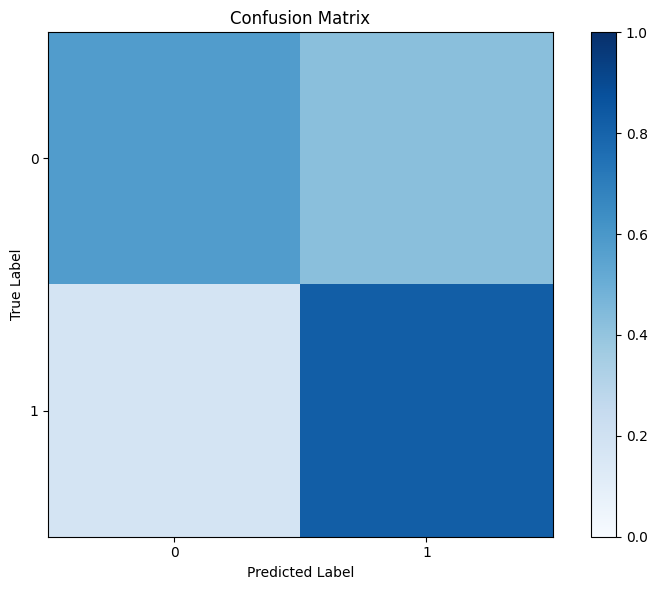

In [8]:
num_classes = len(np.unique(y_train))
y_pred = classifier.predict(x_test_)
# y_pred_classes = np.argmax(y_pred, axis=1)

threshold = 0.5
y_pred_classes = np.zeros_like(y_pred[:, 1])  # Initialize as class 0
y_pred_classes[y_pred[:, 1] > threshold] = 1  

# Calculate confusion matrix
cm = confusion_matrix(y_test_, y_pred_classes)

class_sums = cm.sum(axis=1, keepdims=True)
conf_matrix_normalized = cm / class_sums

print(conf_matrix_normalized)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_normalized, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[[0.53153153 0.46846847]
 [0.17857143 0.82142857]]


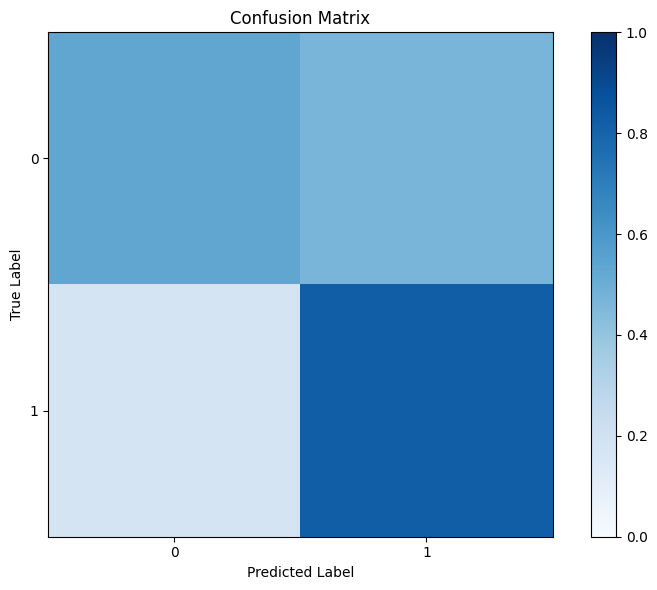

In [7]:
num_classes = len(np.unique(y_train))
y_pred = classifier.predict(x_test_)
# y_pred_classes = np.argmax(y_pred, axis=1)

threshold = 0.5
y_pred_classes = np.zeros_like(y_pred[:, 1])  # Initialize as class 0
y_pred_classes[y_pred[:, 1] > threshold] = 1  

# Calculate confusion matrix
cm = confusion_matrix(y_test_, y_pred_classes)

class_sums = cm.sum(axis=1, keepdims=True)
conf_matrix_normalized = cm / class_sums

print(conf_matrix_normalized)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_normalized, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [10]:
images_x_test = decoder.predict(x_test_)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [14]:
len(np.nonzero(y_pred_classes==y_test_)[0])/len(y_pred_classes)

0.6258992805755396

In [15]:
len(np.nonzero(y_pred_classes)[0])/len(y_pred_classes)

0.4460431654676259

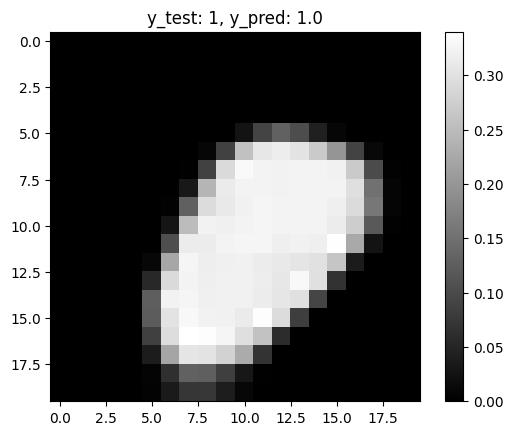

In [13]:
idx = 2
plt.imshow(images_x_test[idx,:,:,0], cmap='gray')
plt.title(f'y_test: {y_test_[idx]}, y_pred: {y_pred_classes[idx]}')
plt.colorbar()

In [14]:
images_x_val, images_x_test_, img_y_val, img_y_test_ = train_test_split(x_test, y_test, test_size=0.5, random_state=42) # 42 random state


In [15]:
x_test_.shape

(139, 10)

/var/folders/ds/_m8m03r135b5r67hc6xgtxt00000gn/T/ipykernel_43488/3957870031.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


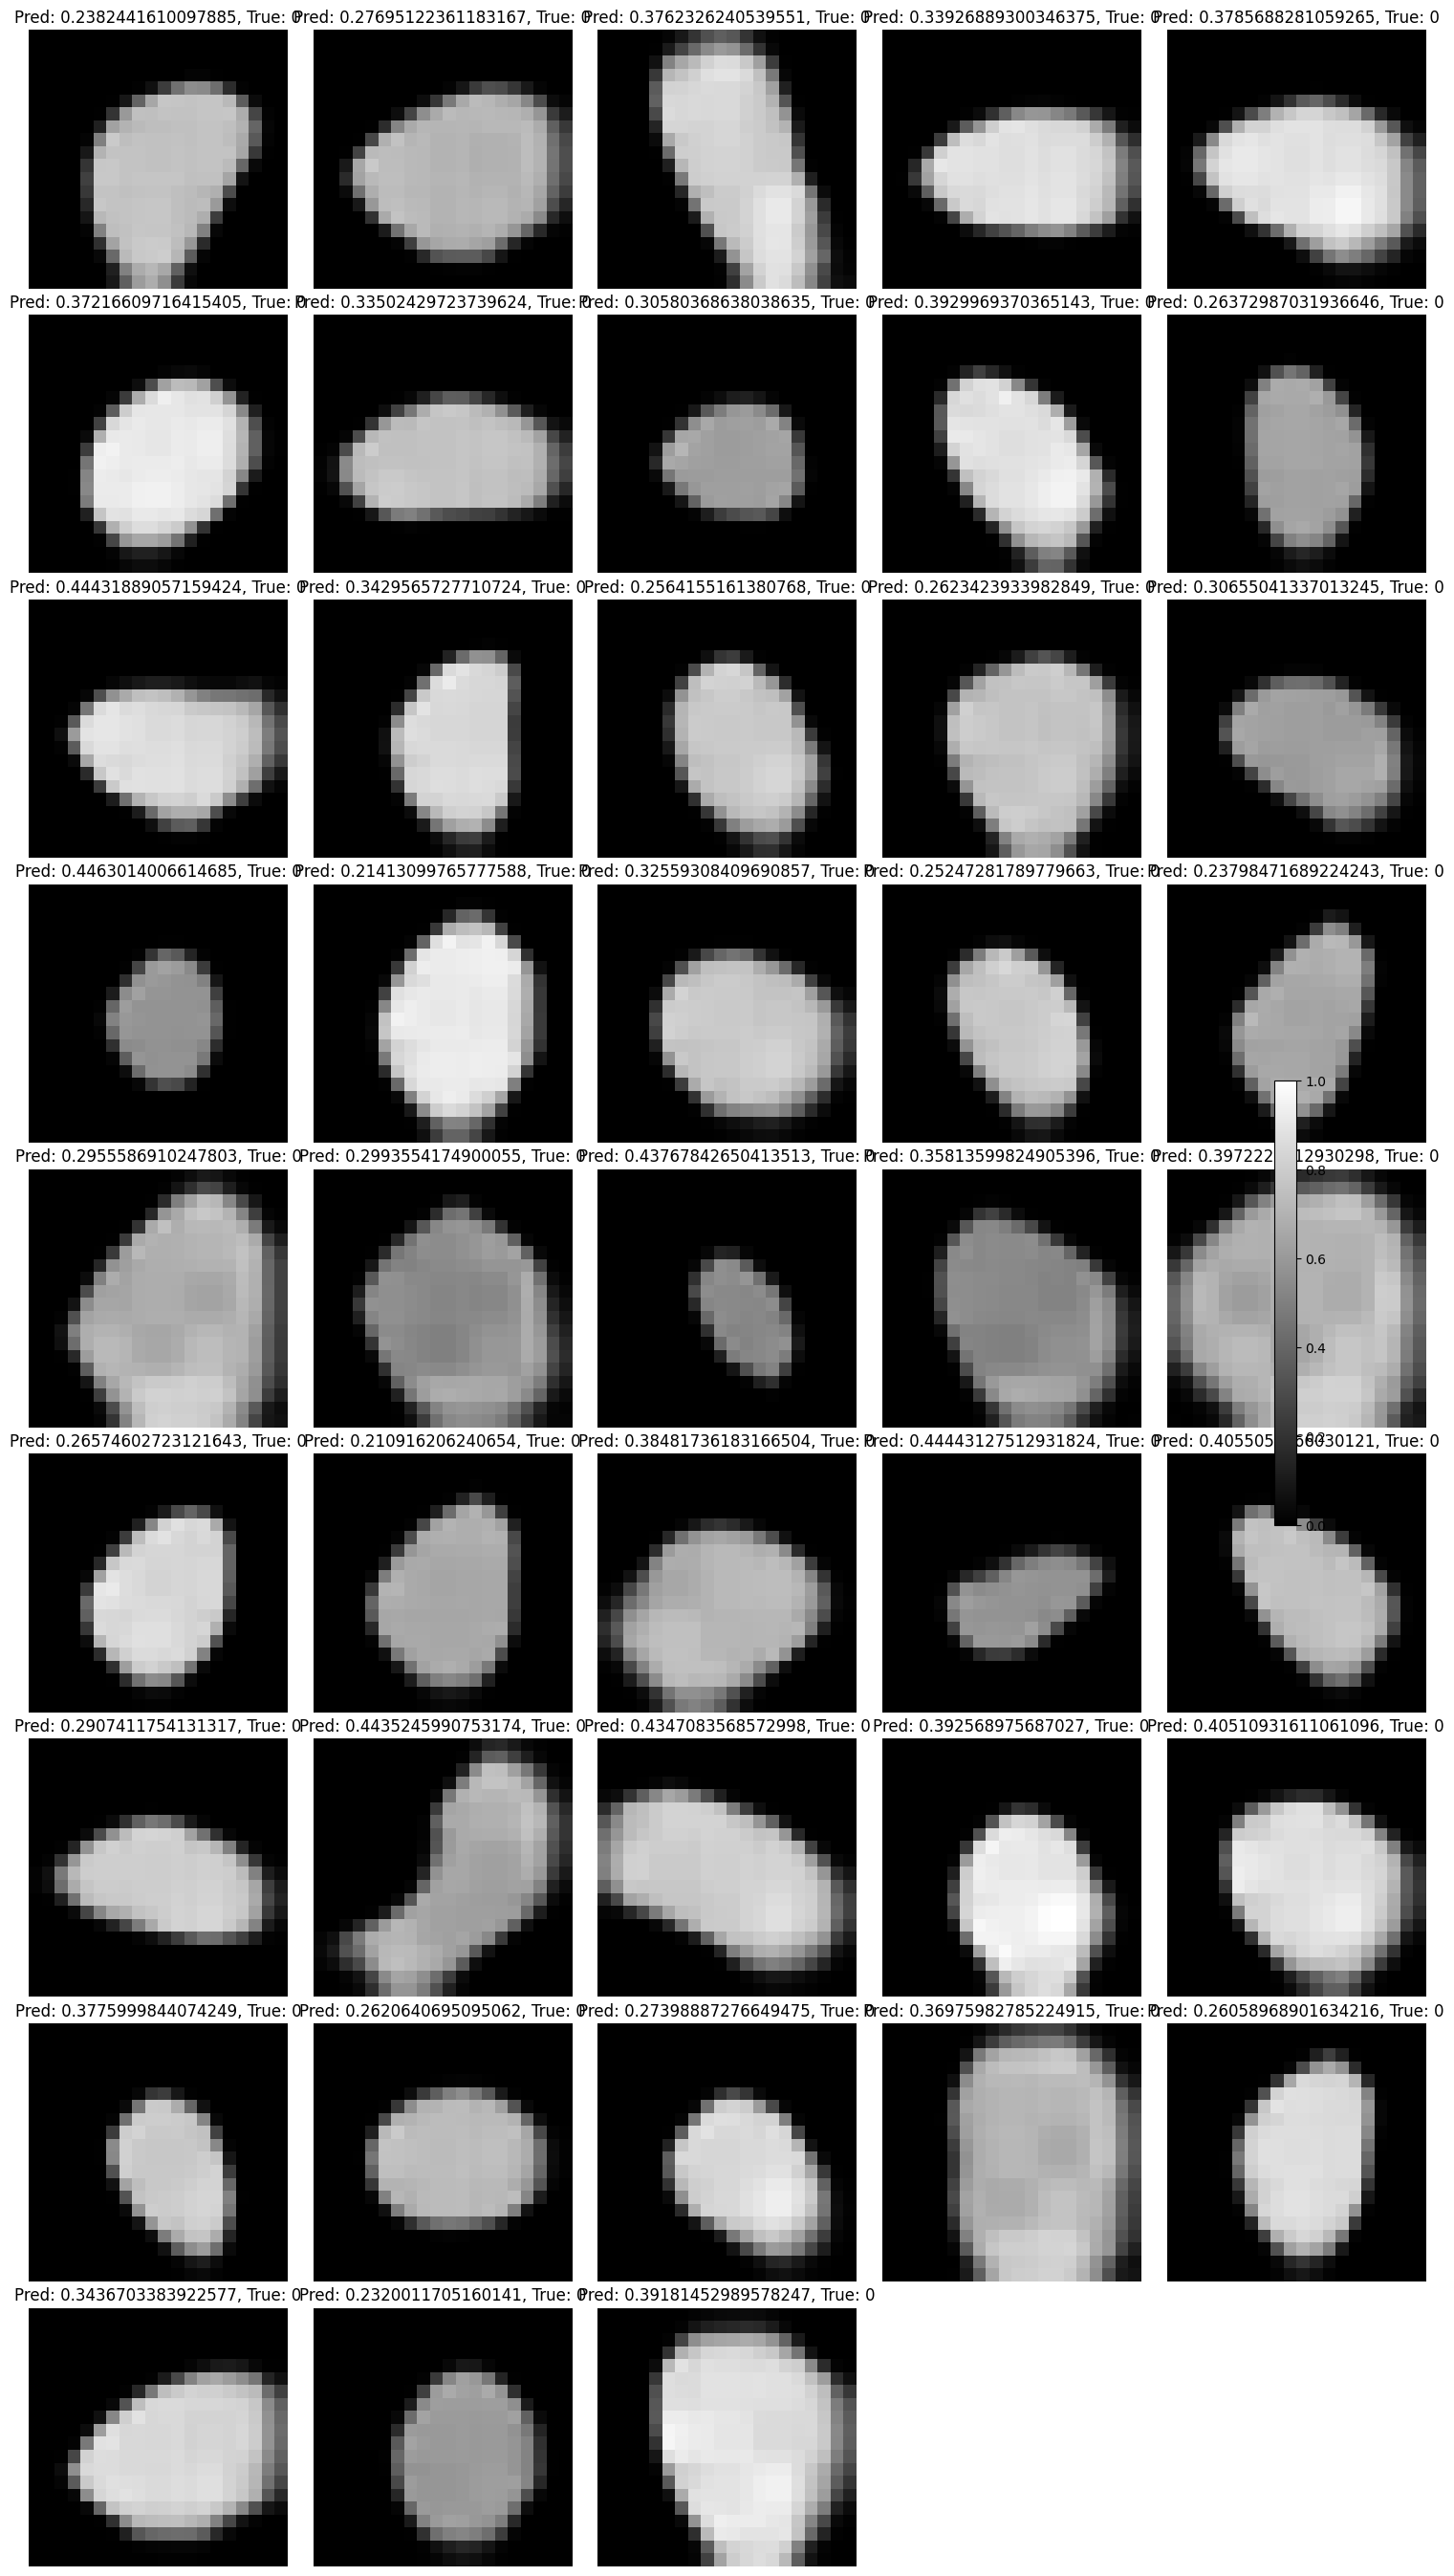

In [16]:
# Identify indices where y_pred_classes is 1 and y_test_ is 0
specific_mismatch_indices = np.where((y_pred_classes == 1) & (y_test_ == 0))[0]

# Find the global maximum for consistent scaling across all images
global_max = np.max(images_x_test[specific_mismatch_indices, :, :])

# Number of images to display
num_images = len(specific_mismatch_indices)

# Determine the grid size for plotting
cols = 5  # Number of columns
rows = (num_images + cols - 1) // cols  # Number of rows

# Create a figure
fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))

# Flatten axes for easy indexing
axes = axes.ravel()

# Plot each mismatched image
for i, idx in enumerate(specific_mismatch_indices):
    ax = axes[i]
    img = images_x_test[idx, :, :] / global_max  # Normalize the image
    im = ax.imshow(img, cmap='gray', vmin=0, vmax=1)
    ax.set_title(f"Pred: {y_pred[idx,0]}, True: {y_test_[idx]}")
    ax.axis('off')  # Remove axis ticks

# Remove unused subplots
for j in range(len(specific_mismatch_indices), len(axes)):
    axes[j].axis('off')

# Add a single colorbar for all images
fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.05)

plt.tight_layout()
plt.show()


/var/folders/ds/_m8m03r135b5r67hc6xgtxt00000gn/T/ipykernel_43488/4010906926.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


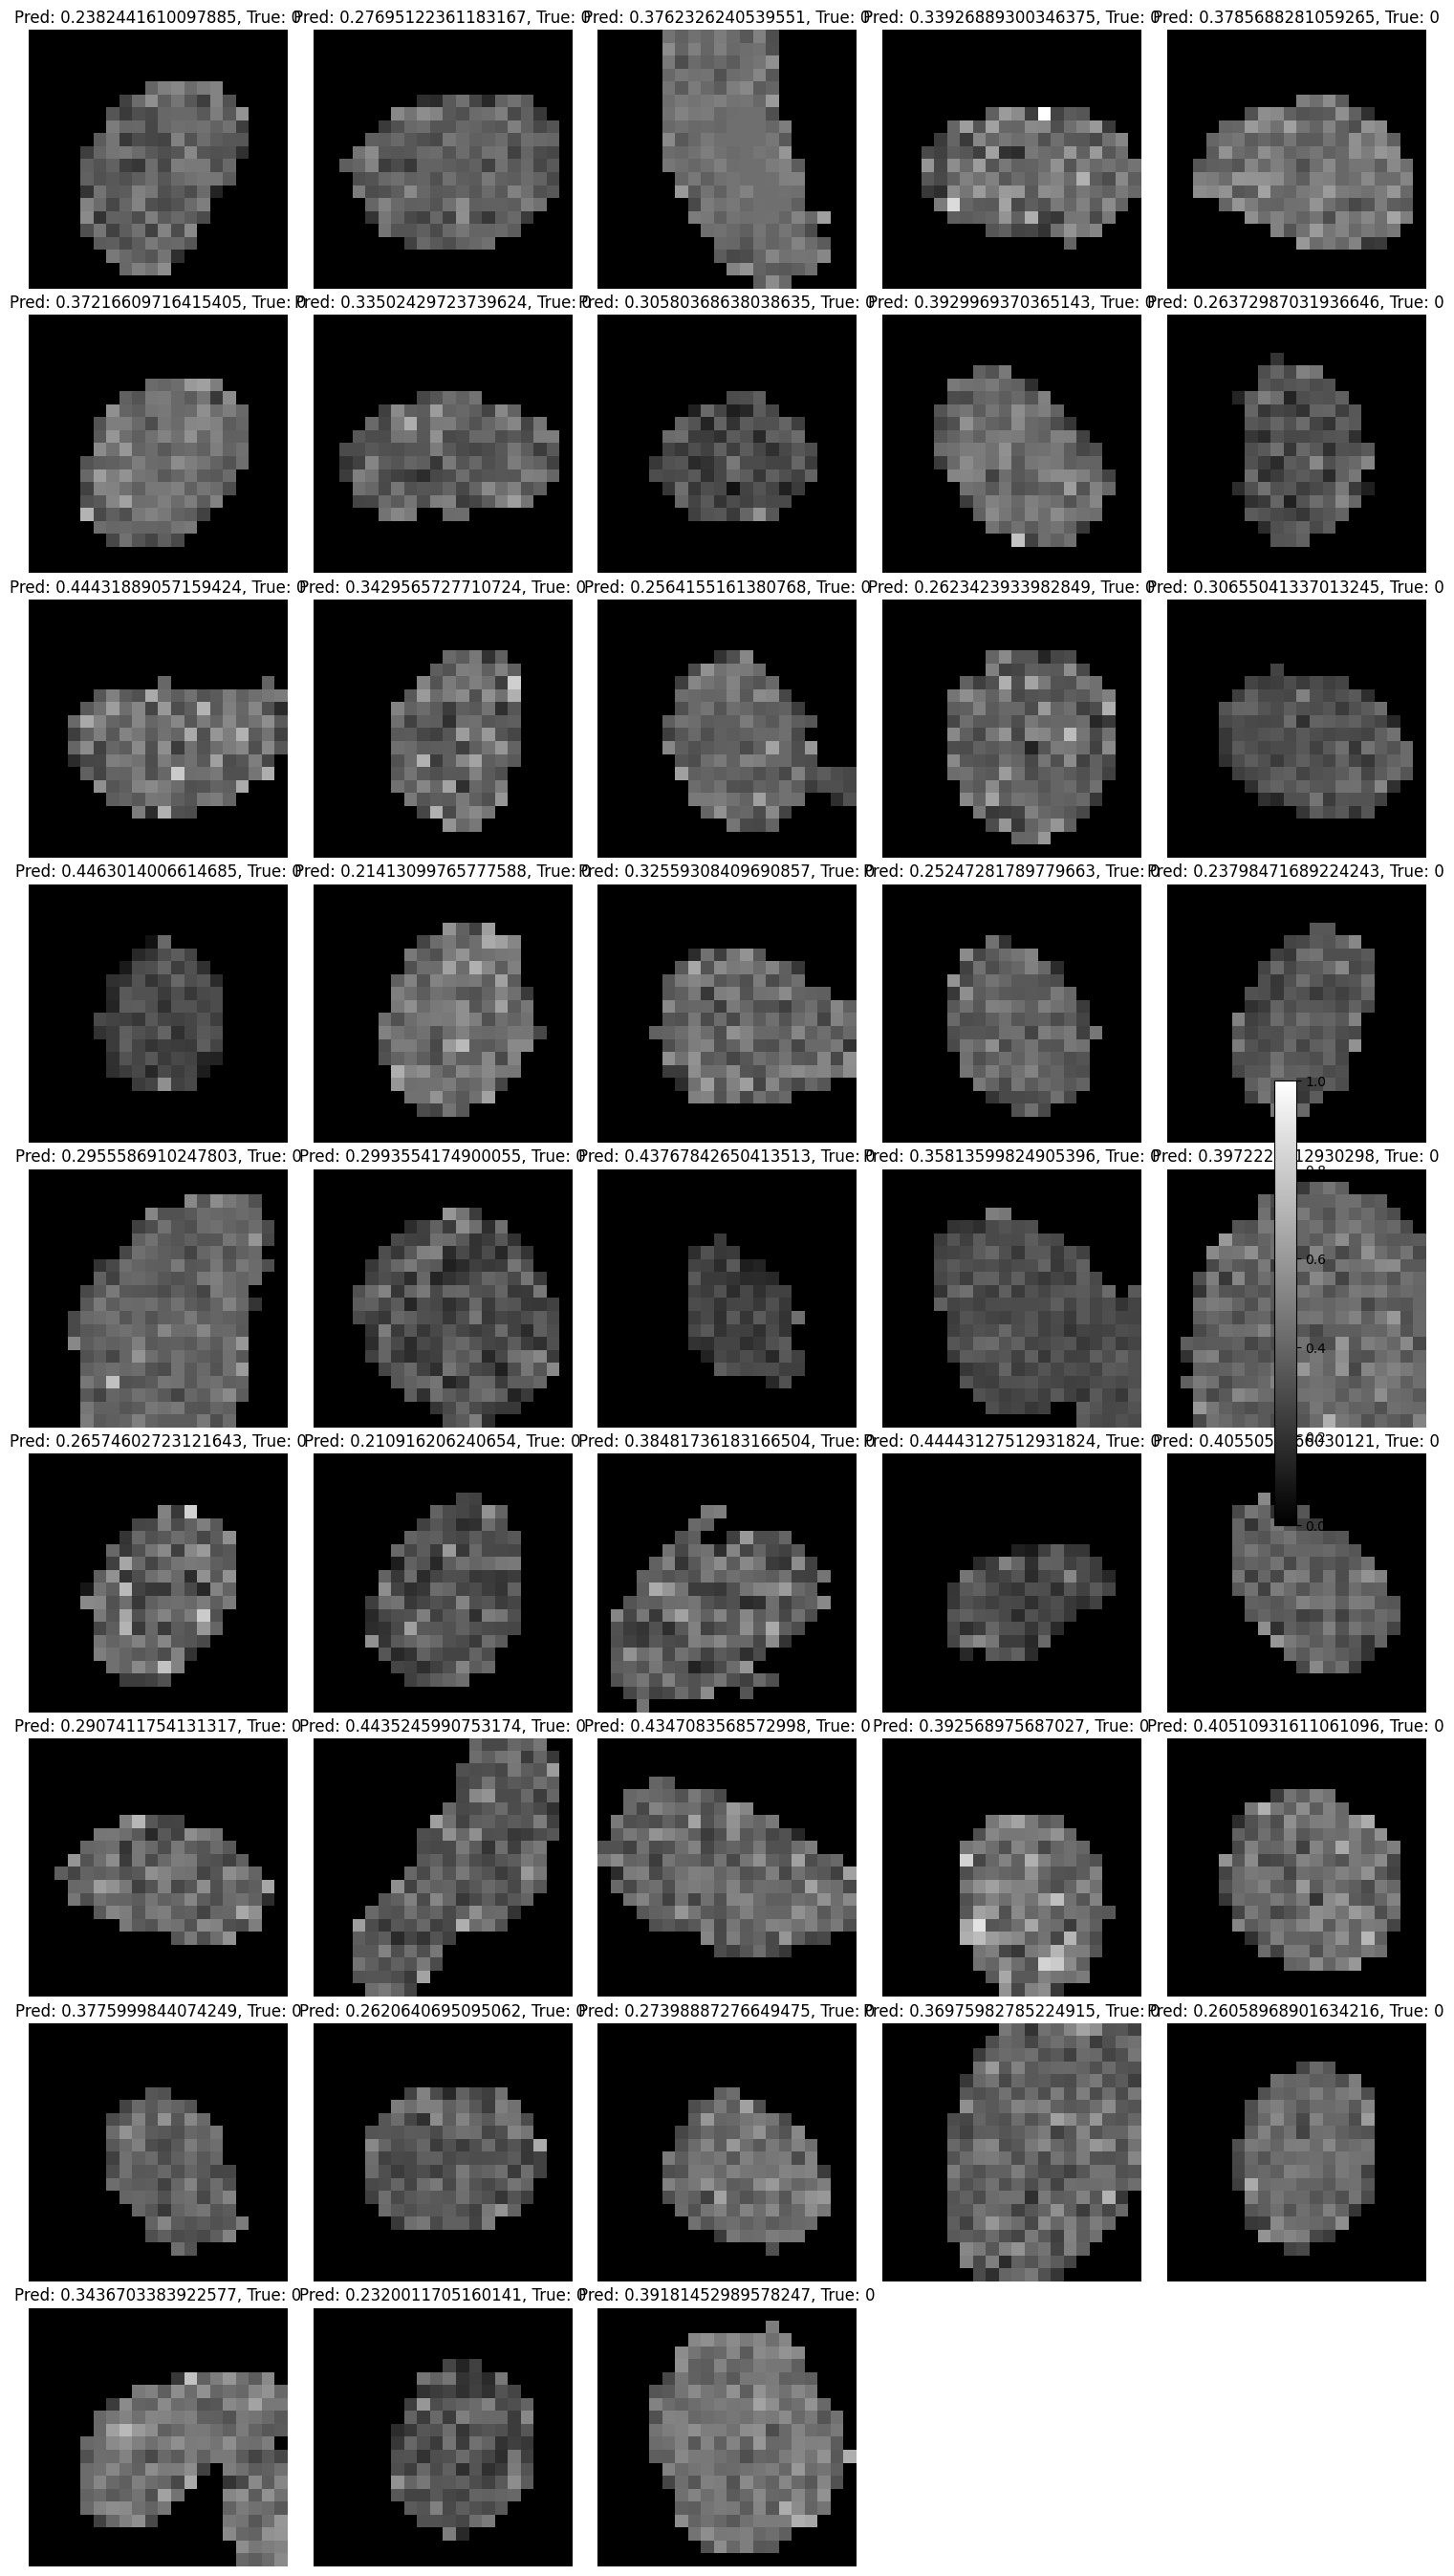

In [17]:
# Identify indices where y_pred_classes is 1 and y_test_ is 0
specific_mismatch_indices = np.where((y_pred_classes == 1) & (y_test_ == 0))[0]

# Find the global maximum for consistent scaling across all images
global_max = np.max(images_x_test_[specific_mismatch_indices, :, :])

# Number of images to display
num_images = len(specific_mismatch_indices)

# Determine the grid size for plotting
cols = 5  # Number of columns
rows = (num_images + cols - 1) // cols  # Number of rows

# Create a figure
fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))

# Flatten axes for easy indexing
axes = axes.ravel()

# Plot each mismatched image
for i, idx in enumerate(specific_mismatch_indices):
    ax = axes[i]
    img = images_x_test_[idx, :, :] / global_max  # Normalize the image
    im = ax.imshow(img, cmap='gray', vmin=0, vmax=1)
    ax.set_title(f"Pred: {y_pred[idx,0]}, True: {y_test_[idx]}")
    ax.axis('off')  # Remove axis ticks

# Remove unused subplots
for j in range(len(specific_mismatch_indices), len(axes)):
    axes[j].axis('off')

# Add a single colorbar for all images
fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.05)

plt.tight_layout()
plt.show()


In [18]:
y_pred.shape

(139, 2)

In [9]:
def visualize_latent_space(latent_space, y_train):
    """Visualize latent space features and their correlation with labels."""
    cor_vals = [np.corrcoef(np.eye(2)[y_train][:, 0], latent_space[:, i])[0, 1] for i in range(latent_space.shape[1])]
    cor_vals = np.array(cor_vals)
    feat_0, feat_1 = np.argsort(np.abs(cor_vals))[-2:]  # Find top 2 correlated features

    print(f"Top correlated features: {feat_0}, {feat_1}")

    # Scatter plot
    scatter = plt.scatter(latent_space[:, feat_0], latent_space[:, feat_1], c=y_train, cmap='viridis', alpha=0.7)
    plt.xlabel(f"Latent Variable {feat_0}")
    plt.ylabel(f"Latent Variable {feat_1}")
    plt.title("Latent Space")
    plt.grid(True)

    # Add legend
    handles, _ = scatter.legend_elements()
    plt.legend(handles, ['Fate 0', 'Fate 1'], title="Classes", loc="lower right")

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Top correlated features: 8, 2


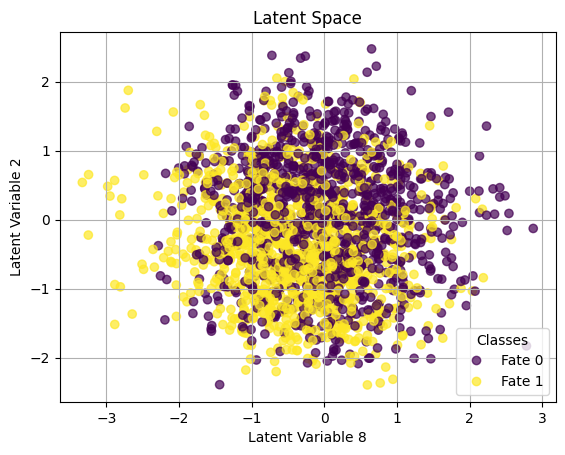

In [18]:
visualize_latent_space(encoder.predict(x_train)[0], y_train)

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Top correlated features: 7, 5


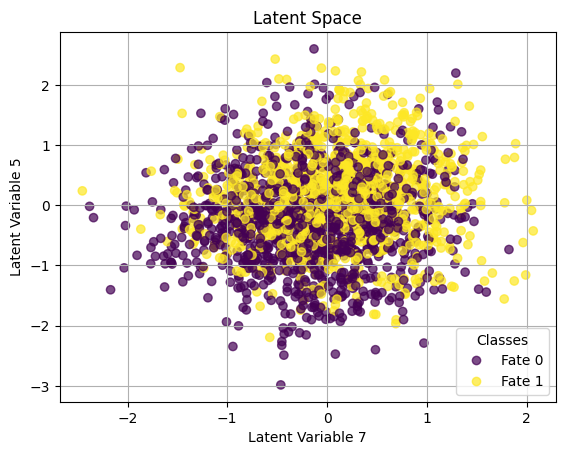

In [10]:
visualize_latent_space(encoder.predict(x_train)[0], y_train)

In [31]:
x_test_.shape

(139, 6)

(2, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
(2, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
(2, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
(2, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
(2, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
(2, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
(2, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


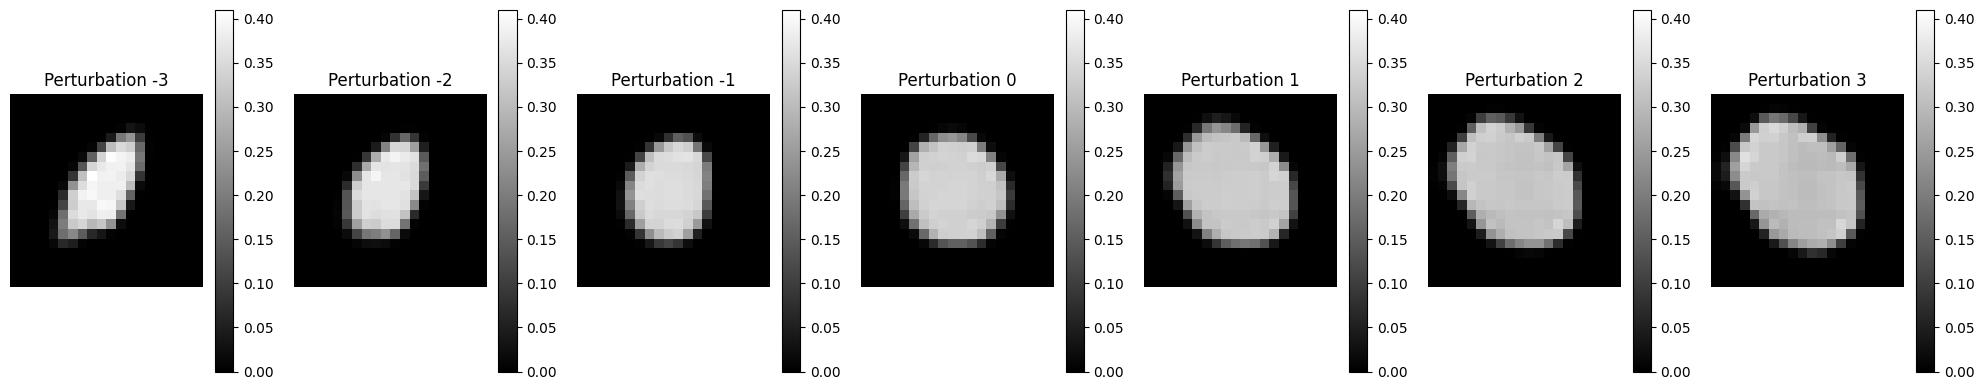

In [13]:
baseline_latent_vector = np.zeros((2, 10), dtype=np.float32)  # Start with a neutral latent vector

# Choose the feature to perturb (e.g., feature 0)
feature_index = 5

# Perturbation range
perturbations = [-3, -2, -1, 0, 1, 2, 3] 
#perturbations = np.linspace(-3, 3, 7)

# Store the perturbed reconstructions
perturbed_reconstructions = []

for value in perturbations:
    # Create a copy of the baseline latent vector
    perturbed_vector = baseline_latent_vector.copy()
    print(perturbed_vector.shape)
    # Modify the selected feature
    perturbed_vector[0, feature_index] = value
    
    # Decode the perturbed vector to generate a synthetic image
    synthetic_image = decoder.predict(perturbed_vector)  # Assuming 'decoder' is your trained decoder model
    
    # Store the result
    perturbed_reconstructions.append(synthetic_image[0])  # Assuming decoder outputs (batch_size, height, width, channels)

# Convert list to numpy array for easier handling
perturbed_reconstructions = np.array(perturbed_reconstructions)

# Plot the results
fig, axs = plt.subplots(1, 7, figsize=(20, 4))
vmin = perturbed_reconstructions.min()
vmax = perturbed_reconstructions.max()

for i in range(7):
    im = axs[i].imshow(perturbed_reconstructions[i, :, :, 0], cmap='gray', vmin=vmin, vmax=vmax)
    axs[i].set_title(f'Perturbation {perturbations[i]}')
    axs[i].axis('off')
    fig.colorbar(im, ax=axs[i])

plt.tight_layout()
plt.show()


(2, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
(2, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
(2, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
(2, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
(2, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
(2, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
(2, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


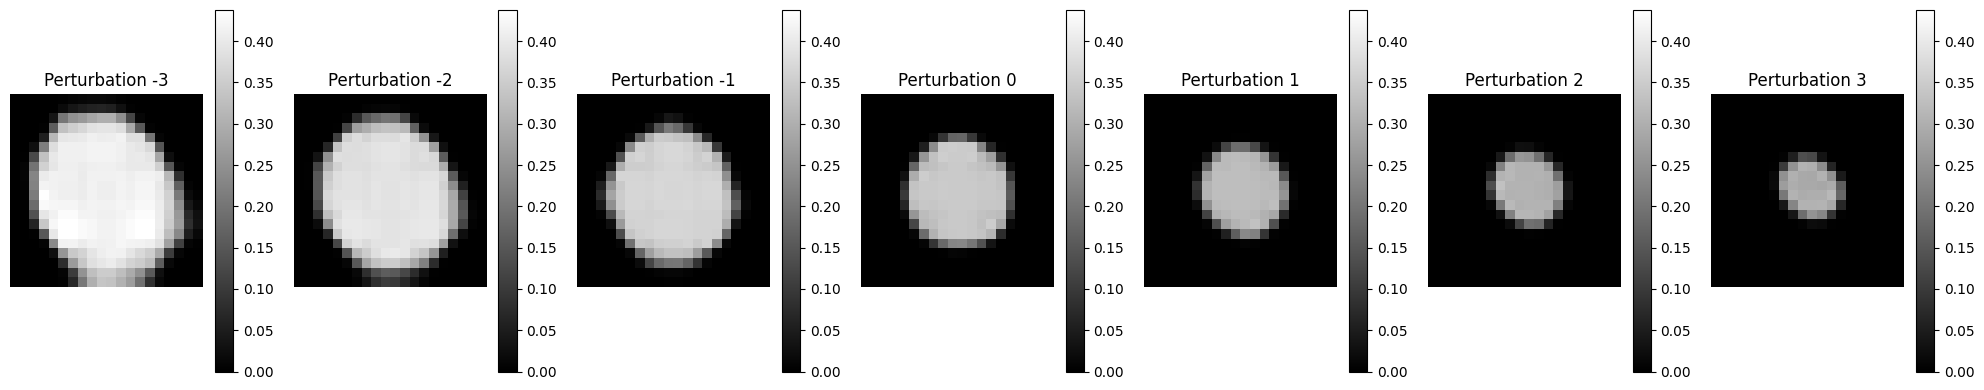

In [17]:
baseline_latent_vector = np.zeros((2, 10), dtype=np.float32)  # Start with a neutral latent vector

# Choose the feature to perturb (e.g., feature 0)
feature_index = 7

# Perturbation range
perturbations = [-3, -2, -1, 0, 1, 2, 3] 
#perturbations = np.linspace(-3, 3, 7)

# Store the perturbed reconstructions
perturbed_reconstructions = []

for value in perturbations:
    # Create a copy of the baseline latent vector
    perturbed_vector = baseline_latent_vector.copy()
    print(perturbed_vector.shape)
    # Modify the selected feature
    perturbed_vector[0, feature_index] = value
    
    # Decode the perturbed vector to generate a synthetic image
    synthetic_image = decoder.predict(perturbed_vector)  # Assuming 'decoder' is your trained decoder model
    
    # Store the result
    perturbed_reconstructions.append(synthetic_image[0])  # Assuming decoder outputs (batch_size, height, width, channels)

# Convert list to numpy array for easier handling
perturbed_reconstructions = np.array(perturbed_reconstructions)

# Plot the results
fig, axs = plt.subplots(1, 7, figsize=(20, 4))
vmin = perturbed_reconstructions.min()
vmax = perturbed_reconstructions.max()

for i in range(7):
    im = axs[i].imshow(perturbed_reconstructions[i, :, :, 0], cmap='gray', vmin=vmin, vmax=vmax)
    axs[i].set_title(f'Perturbation {perturbations[i]}')
    axs[i].axis('off')
    fig.colorbar(im, ax=axs[i])

plt.tight_layout()
plt.show()


(2, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
(2, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
(2, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
(2, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
(2, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
(2, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
(2, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
(2, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


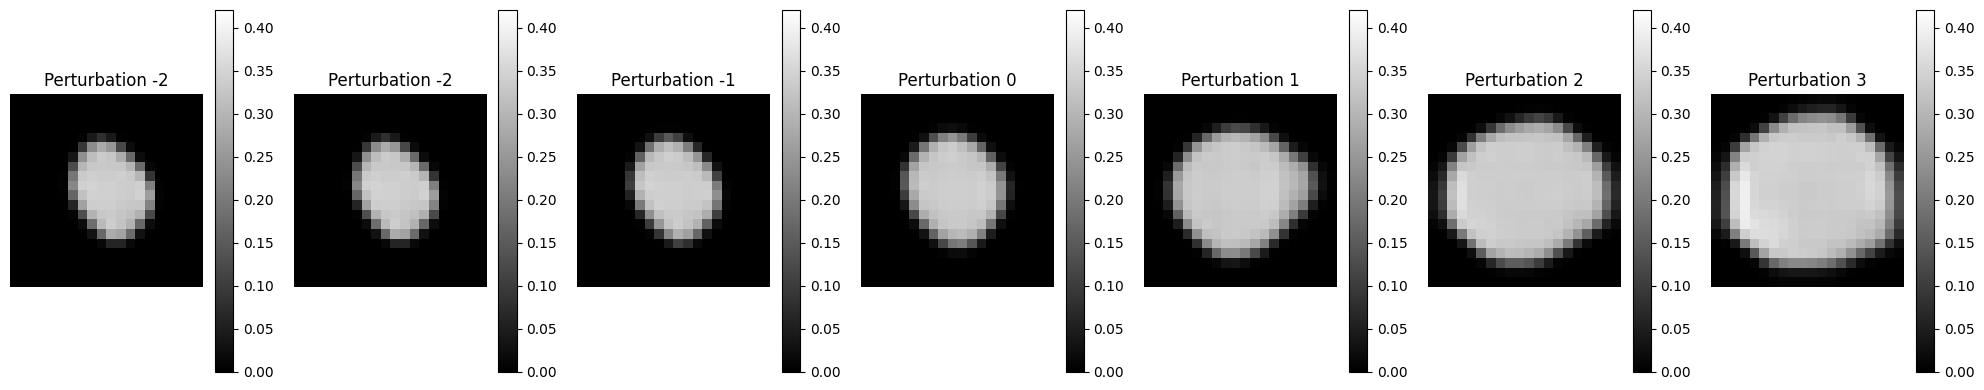

In [56]:
baseline_latent_vector = np.zeros((2, 10), dtype=np.float32)  # Start with a neutral latent vector

# Choose the feature to perturb (e.g., feature 0)
feature_index = 8

# Perturbation range
perturbations = [-2, -2, -1, 0, 1, 2, 3, 4] 
#perturbations = np.linspace(-3, 3, 7)

# Store the perturbed reconstructions
perturbed_reconstructions = []

for value in perturbations:
    # Create a copy of the baseline latent vector
    perturbed_vector = baseline_latent_vector.copy()
    print(perturbed_vector.shape)
    # Modify the selected feature
    perturbed_vector[0, feature_index] = value
    
    # Decode the perturbed vector to generate a synthetic image
    synthetic_image = decoder.predict(perturbed_vector)  # Assuming 'decoder' is your trained decoder model
    
    # Store the result
    perturbed_reconstructions.append(synthetic_image[0])  # Assuming decoder outputs (batch_size, height, width, channels)

# Convert list to numpy array for easier handling
perturbed_reconstructions = np.array(perturbed_reconstructions)

# Plot the results
fig, axs = plt.subplots(1, 7, figsize=(20, 4))
vmin = perturbed_reconstructions.min()
vmax = perturbed_reconstructions.max()

for i in range(7):
    im = axs[i].imshow(perturbed_reconstructions[i, :, :, 0], cmap='gray', vmin=vmin, vmax=vmax)
    axs[i].set_title(f'Perturbation {perturbations[i]}')
    axs[i].axis('off')
    fig.colorbar(im, ax=axs[i])

plt.tight_layout()
plt.show()


In [48]:
new_x_train = np.load("../data/train_images.npy")

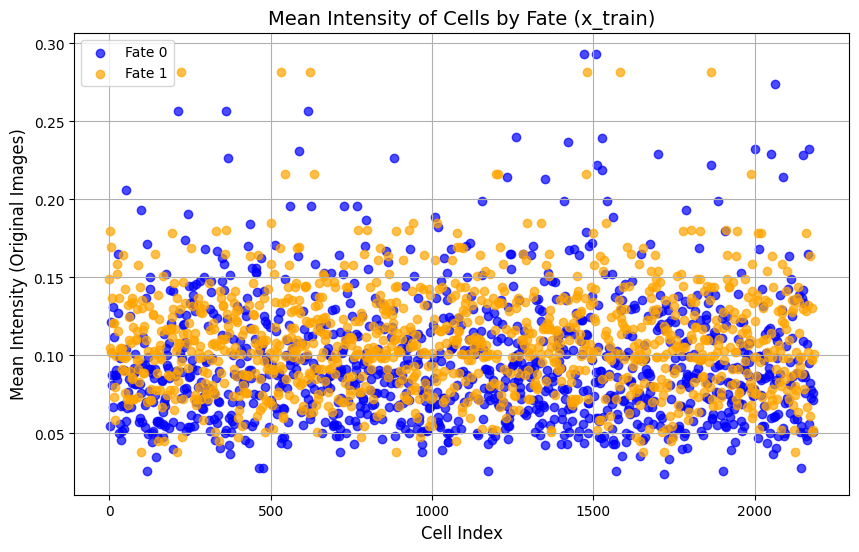

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Compute mean intensity values for x_train
mean_intensity_x_train = np.mean(x_train, axis=(1, 2))  # Average over height, width, and channels

# Separate indices by labels
fate_0_indices = np.where(y_train == 0)[0]
fate_1_indices = np.where(y_train == 1)[0]

# Scatter plot
plt.figure(figsize=(10, 6))

# Plot for fate 0
plt.scatter(
    fate_0_indices,
    mean_intensity_x_train[fate_0_indices],
    label="Fate 0",
    alpha=0.7,
    color="blue"
)

# Plot for fate 1
plt.scatter(
    fate_1_indices,
    mean_intensity_x_train[fate_1_indices],
    label="Fate 1",
    alpha=0.7,
    color="orange"
)

# Add labels, legend, and title
plt.xlabel("Cell Index", fontsize=12)
plt.ylabel("Mean Intensity (Original Images)", fontsize=12)
plt.title("Mean Intensity of Cells by Fate (x_train)", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()


## Tracks data

In [124]:
tracks = np.load("../data/filtered_tracks.npy")
y_train_tracks = np.load("../data/filteresd_y_train.npy")
print(tracks.shape)

(1385, 10)


In [125]:
x_train_tracks = tracks[:,4:8]

In [109]:
indexes_with_no_fret = np.where(x_train_tracks[:,0] == 0.0)

In [165]:
bla = np.delete(x_train_tracks, 3, axis=1)

In [166]:
new_x_train_tracks = np.delete(x_train_tracks, indexes_with_no_fret, axis=0)
new_y_train_tracks = np.delete(y_train_tracks, indexes_with_no_fret, axis=0)

In [173]:
train_indexes, test_indexes = train_test_split(
        np.arange(len(y_train_tracks)),
        test_size=0.2,
        stratify=y_train_tracks,
        random_state=42
    )

train_tracks = x_train_tracks[train_indexes]
test_tracks = x_train_tracks[test_indexes]
y_train_track_ = y_train_tracks[train_indexes]
y_test_track_ = y_train_tracks[test_indexes]

In [174]:
y_test_track_.shape

(277,)

In [182]:
from tensorflow.keras import layers, Sequential
import tensorflow as tf
from tensorflow.keras.regularizers import l2

def mlp_classifier(latent_dim):
    return Sequential([
        layers.Input(shape=(latent_dim,)),
        layers.BatchNormalization(),
        layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)), #
        layers.Dropout(0.3),
        layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        layers.Dropout(0.3),
       # layers.Dense(16, activation='relu'),
        layers.Dense(2, activation='softmax')
    ])

In [183]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_tracks.flatten()), y=y_train_tracks.flatten())
class_weights = dict(enumerate(class_weights))

tf.keras.utils.set_random_seed(config['seed'])

classifier = mlp_classifier(latent_dim=x_train_tracks.shape[1]) #[:, [3, 8]] 

# Train the classifier
classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config['learning_rate']), metrics=['accuracy'])
classifier.summary()

x_val_tracks, x_test_tracks, y_val_tracks, y_test_tracks = train_test_split(test_tracks, y_test_track_, test_size=0.5, random_state=42) # 42 random state

history = classifier.fit(train_tracks, y_train_track_, batch_size=config['batch_size'], epochs=config['epochs'], validation_data=(x_val_tracks, y_val_tracks), class_weight=class_weights) # 

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_26          │ (None, 4)              │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 250 (1000.00 B)

 Trainable params: 242 (968.00 B)

 Non-trainable params: 8 (32.00 B)

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7421 - loss: 0.9160 - val_accuracy: 0.8696 - val_loss: 0.4515
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7058 - loss: 0.7754 - val_accuracy: 0.8478 - val_loss: 0.5081
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - accuracy: 0.6378 - loss: 0.7403 - val_accuracy: 0.6667 - val_loss: 0.6090
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - accuracy: 0.5477 - loss: 0.7005 - val_accuracy: 0.4710 - val_loss: 0.6725
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - accuracy: 0.5325 - loss: 0.6800 - val_accuracy: 0.4130 - val_loss: 0.6971
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - accuracy: 0.5047 - loss: 0.6806 - val_accuracy: 0.4348 - val_loss: 0.7071
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - accuracy: 0.4741 - loss: 0.6683 - val_accuracy: 0.4130 - val_loss: 0.7115
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - accuracy: 0.4857 - loss: 0.6670 - val_accuracy

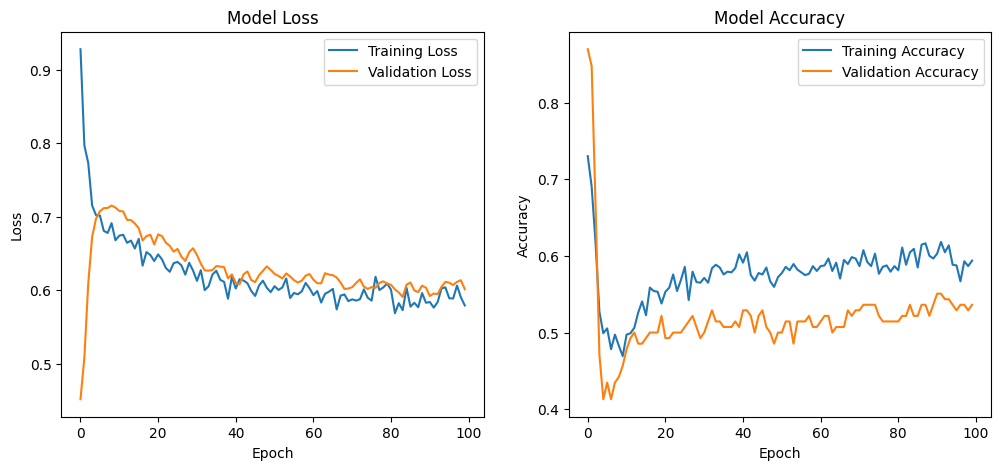

In [184]:
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[[0.5045045 0.4954955]
 [0.25      0.75     ]]


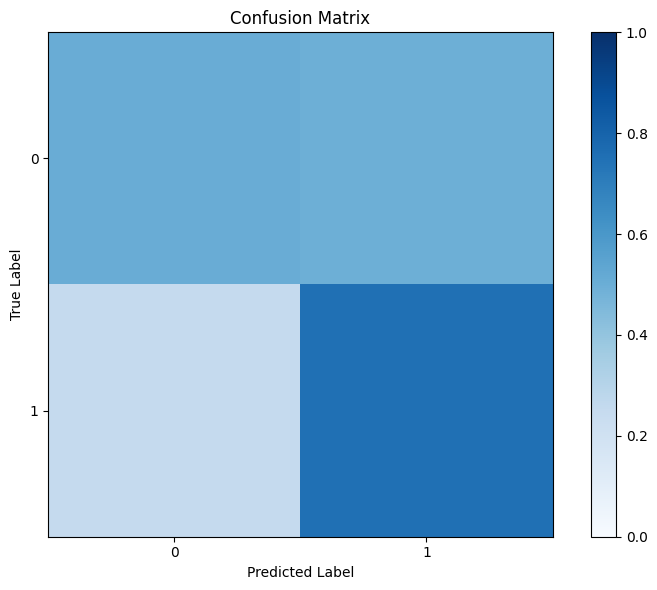

In [185]:
num_classes = len(np.unique(y_train))
y_pred = classifier.predict(x_test_tracks)
# y_pred_classes = np.argmax(y_pred, axis=1)

threshold = 0.5
y_pred_classes = np.zeros_like(y_pred[:, 1])  # Initialize as class 0
y_pred_classes[y_pred[:, 1] > threshold] = 1  

# Calculate confusion matrix
cm = confusion_matrix(y_test_tracks, y_pred_classes)

class_sums = cm.sum(axis=1, keepdims=True)
conf_matrix_normalized = cm / class_sums

print(conf_matrix_normalized)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_normalized, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Feature 2')

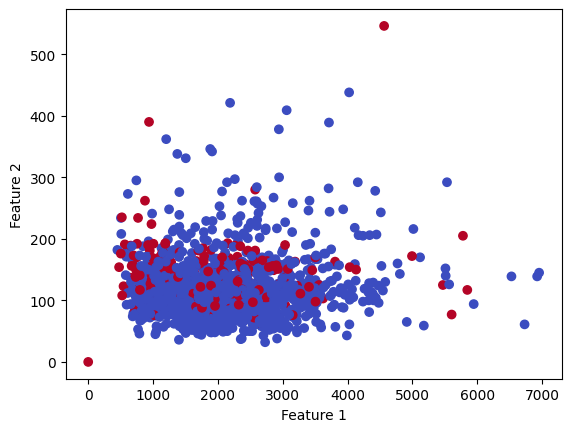

In [135]:
plt.scatter(x_train_tracks[:,1], x_train_tracks[:,2], c=y_train_tracks, cmap='coolwarm')
plt.xlabel('Feature 1') 
plt.ylabel('Feature 2')

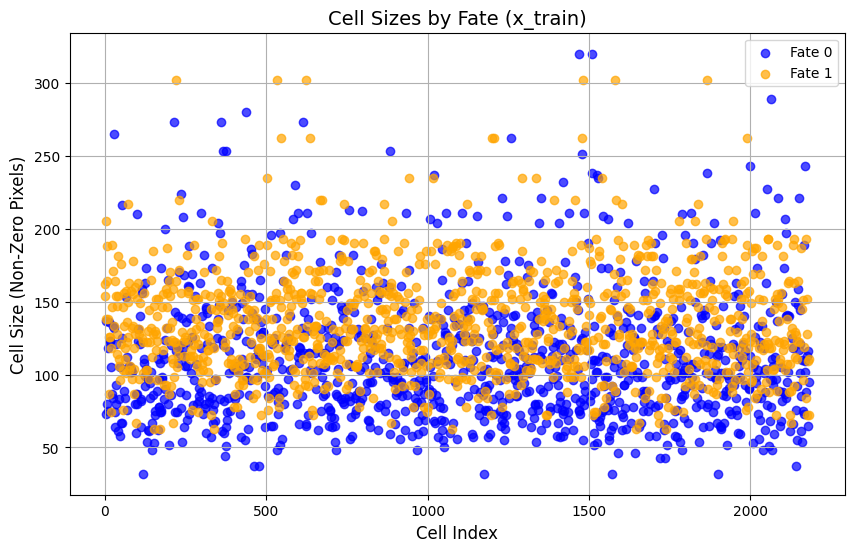

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate cell sizes (number of non-zero pixels per cell)
cell_sizes = np.sum(new_x_train > 0, axis=(1, 2))  # Sum non-zero pixels across height and width

# Separate indices by labels
fate_0_indices = np.where(y_train == 0)[0]
fate_1_indices = np.where(y_train == 1)[0]

# Scatter plot
plt.figure(figsize=(10, 6))

# Plot for fate 0
plt.scatter(
    fate_0_indices,
    cell_sizes[fate_0_indices],
    label="Fate 0",
    alpha=0.7,
    color="blue"
)

# Plot for fate 1
plt.scatter(
    fate_1_indices,
    cell_sizes[fate_1_indices],
    label="Fate 1",
    alpha=0.7,
    color="orange"
)

# Add labels, legend, and title
plt.xlabel("Cell Index", fontsize=12)
plt.ylabel("Cell Size (Non-Zero Pixels)", fontsize=12)
plt.title("Cell Sizes by Fate (x_train)", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


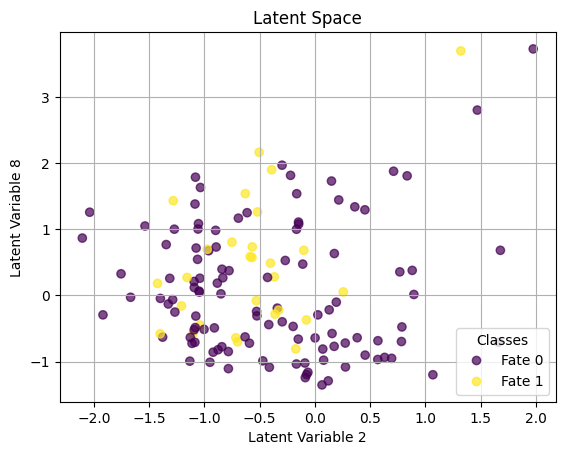

In [42]:
feat_0 = 2
feat_1 = 8
latent_space = encoder.predict(x_train)[0]
scatter = plt.scatter(x_test_[:, feat_0], x_test_[:, feat_1], c=y_test_, cmap='viridis', alpha=0.7)
plt.xlabel(f"Latent Variable {feat_0}")
plt.ylabel(f"Latent Variable {feat_1}")
plt.title("Latent Space")
plt.grid(True)

# Add legend
handles, _ = scatter.legend_elements()
plt.legend(handles, ['Fate 0', 'Fate 1'], title="Classes", loc="lower right")